In [4]:
!pip install -q git+https://github.com/openai/point-e.git
!pip install open3d numpy matplotlib
! pip install plotly -q
!pip install torch torchvision torchaudio numpy
!pip install -e


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^


  Using cached open3d-0.19.0-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
  Using cached ConfigArgParse-1.7-py3-none-any.whl.metadata (23 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
Using cached open3d-0.19.0-cp312-cp312-win_amd64.whl (69.2 MB)
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached ConfigArgParse-1.7-py3-none-any.whl (25 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 1.0.0
    Uninstalling jupyterlab-widge

    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^
    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument


In [8]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


c:\Users\chakr\anaconda3\Lib\site-packages\point_e\models\download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


<All keys matched successfully>

In [12]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [14]:
# Set a prompt to condition on.
prompt = 'a tree'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

In [15]:
pc = sampler.output_to_point_clouds(samples)[0]

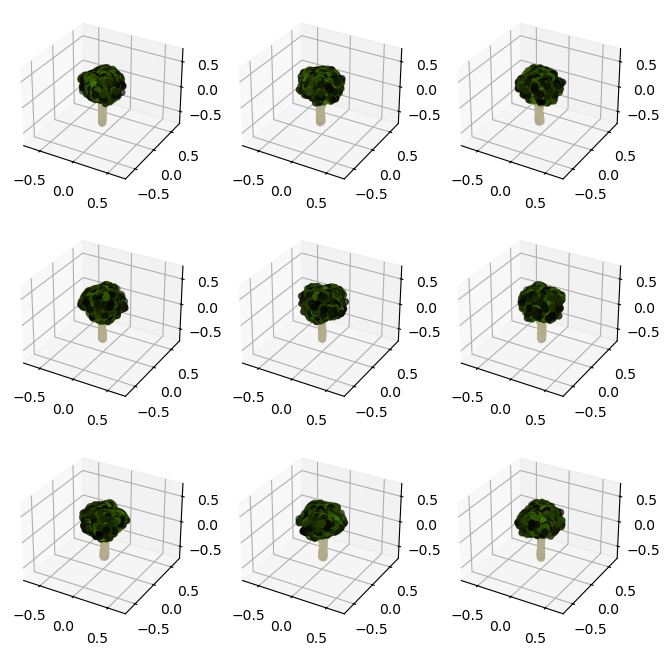

In [16]:
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [17]:
import plotly.graph_objects as go

fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [18]:
fig_plotly.show()


In [19]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


c:\Users\chakr\anaconda3\Lib\site-packages\point_e\models\download.py:78: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [21]:
import skimage.measure as measure


In [22]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
# Write the mesh to a PLY file to import into some other program.
with open('tree.ply', 'wb') as f:
    mesh.write_ply(f)